In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


In [2]:
train = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/train.csv")
test = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/test.csv")
sample = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv")
updates = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv")


In [3]:
train.shape

(31390, 5)

In [4]:
train.head(1)

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7


Probablemente una distribución que se acerca bastante a la gama

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


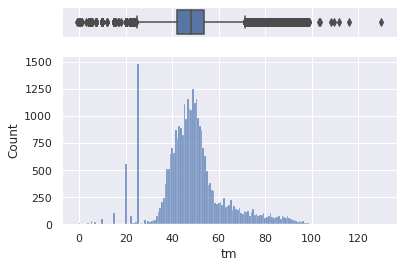

count    31390.000000
mean        49.147337
std         14.010089
min         -1.000000
25%         42.100000
50%         48.000000
75%         53.800000
max        130.000000
Name: tm, dtype: float64


In [5]:

sns.set(style="darkgrid")
 
# creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# assigning a graph to each ax
sns.boxplot(train["tm"], ax=ax_box)
sns.histplot(data=train, x="tm", ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
plt.show()

print(train.tm.describe())

count    31104.000000
mean         6.892339
std          1.612225
min          1.990000
25%          7.000000
50%          7.000000
75%          7.000000
max         64.900000
Name: pH, dtype: float64


<AxesSubplot:ylabel='Frequency'>

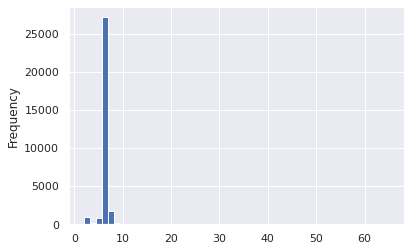

In [6]:
print(train.pH.describe())
train.pH.plot(kind="hist", bins= 50)

Secuencias de las proteinas son casi todas diferentes 28891 de las casi 31 mil

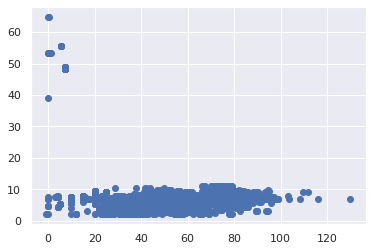

In [7]:
plt.scatter(train.tm, train.pH)
plt.show()

In [8]:
len(train.protein_sequence.unique())

28981

In [9]:
def split_data(df):
    X_train, y_train, X_test, y_test = train_test_split(df, df.tm, test_size = 0.33, random_state = 123)
    return X_train, y_train, X_test, y_test

X_train, X_test , y_train, y_test = split_data(train)
X_train.drop('tm', axis=1, inplace=True)
X_test.drop('tm', axis=1, inplace=True)

In [10]:
def feature_extraction(df):
    df["len_protein"] = df['protein_sequence'].apply(lambda x: len(x))
    df["unique_protein"] = df['protein_sequence'].apply(set).apply(len)
    df["num_A"] = df.protein_sequence.str.count('A')
    df["num_M"] = df.protein_sequence.str.count('M')
    df["num_E"] = df.protein_sequence.str.count('E')
    df["num_N"] = df.protein_sequence.str.count('N')
    df["num_S"] = df.protein_sequence.str.count('S')
    df["num_V"] = df.protein_sequence.str.count('V')
    
    return df

X_train = feature_extraction(X_train)
X_test = feature_extraction(X_test)
    

In [11]:

#letra = "AAABC"
X_train

,seq_id,protein_sequence,pH,data_source,len_protein,unique_protein,num_A,num_M,num_E,num_N,num_S,num_V
18894,18894,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,3.0,10.1016/0022-2836(84)90474-1,164,20,15,4,8,12,6,10
20525,20525,MPNMSSIKAEQQSGPLGGSSGYQVPVNMCTTTVANTTTTLGSSAGG...,7.0,doi.org/10.1038/s41592-020-0801-4,807,20,61,19,47,38,103,36
10626,10626,MFNIVVIASGNGSNFQAVIDAIDSGLINARIIKLISDNERANALNR...,7.0,doi.org/10.1038/s41592-020-0801-4,201,19,12,4,10,15,17,15
10704,10704,MFRGATLVNLDSKGRLSVPTRYREQLLENAAGQMVCTIDIYHPCLL...,7.0,doi.org/10.1038/s41592-020-0801-4,151,20,9,5,13,4,8,9
17781,17781,MMSFVSLLLVGILFHATQAEQLTKCEVFQKLKDLKDYGGVSLPEWV...,3.7,NaN,142,20,7,2,6,8,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...
28636,28636,MVKIVTVKTQAYPDQKPGTSGLRKRVKVFQSNANYAENFIQSIVST...,7.0,doi.org/10.1038/s41592-020-0801-4,561,20,50,12,30,27,35,39
17730,17730,MMNYQYDVSVIIPAKNVEKFLRETLNGLLDQTACENSKIEICLADD...,7.0,doi.org/10.1038/s41592-020-0801-4,356,20,16,6,25,14,24,31
28030,28030,MTTIVGVRAREVLDSRGFPTVEAEVELEGGARGRAMVPSGASTGTH...,7.0,doi.org/10.1038/s41592-020-0801-4,421,19,51,7,43,15,20,37
15725,15725,MLKQVEIFTDGSCLGNPGPGGYGAILRYRGREKTFSAGYTRTTNNR...,5.5,10.1021/bi00416a052,155,20,15,4,12,7,4,8


In [12]:
# Crear nuevo feature con el largo del dataframe
X_train = X_train.drop(["data_source", "protein_sequence"], axis =1)
X_test = X_test.drop(["data_source", "protein_sequence"], axis =1)

X_train.head(1)

,seq_id,pH,len_protein,unique_protein,num_A,num_M,num_E,num_N,num_S,num_V
18894,18894,3.0,164,20,15,4,8,12,6,10


In [13]:
#from sklearn import preprocessing
#lbl = preprocessing.OrdinalEncoder()
#train['protein_sequence'] = lbl.fit_transform(train['protein_sequence'].astype(str))
#test['protein_sequence'] = lbl.fit_transform(test['protein_sequence'].astype(str))

In [14]:
dtrain = xgb.DMatrix(X_train, 
                     label = y_train, )
dtest = xgb.DMatrix(X_test)
# specify parameters via map
param = {'max_depth':10, 'eta':1, 'objective' :'reg:squarederror' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

In [15]:

test = feature_extraction(test)
test = test.drop(["protein_sequence", "data_source"], axis =1)
test.head()

,seq_id,pH,len_protein,unique_protein,num_A,num_M,num_E,num_N,num_S,num_V
0,31390,8,221,18,22,0,8,19,18,13
1,31391,8,221,18,22,0,7,19,18,13
2,31392,8,220,18,22,0,7,19,18,13
3,31393,8,221,18,22,0,7,19,18,13
4,31394,8,221,18,22,0,7,19,18,13


In [16]:
last_test = xgb.DMatrix(test)
preds = bst.predict(last_test)

In [17]:
sample["tm"] = preds

<AxesSubplot:ylabel='Frequency'>

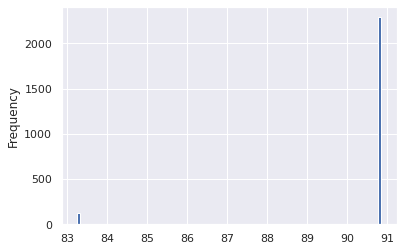

In [18]:
sample.tm.plot(kind ="hist", bins =100)

In [19]:
sample.to_csv("output.csv", index = False)